In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense,  LSTM
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta

# inputフォルダに格納されているファイルの一覧を出力
BASE_PATH = '/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input'

for dirname, _, filenames in os.walk(BASE_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# データファイルの読み込み
item_categories = pd.read_csv(BASE_PATH + '/item_categories.csv')
items = pd.read_csv(BASE_PATH + '/items.csv')
sales_train = pd.read_csv(BASE_PATH + '/sales_train.csv')
sample_submission = pd.read_csv(BASE_PATH + '/sample_submission.csv')
shops = pd.read_csv(BASE_PATH + '/shops.csv')
test = pd.read_csv(BASE_PATH + '/test.csv')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/item_categories.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/items.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/sales_train.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/sample_submission.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/shops.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/test.csv


In [3]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
# 予測対象のファイル(test)をベースに、
# 2013年1月(date_block_num=0)〜2015年11月(date_block_num=35)まで増幅する
test_201301to201511 = test.copy()

test_201301to201511['crossjoin_key'] = 1

data_fill = pd.DataFrame({'crossjoin_key' : 1,
                          'date_block_num' : range(0, 35)})

test_201301to201511 = pd.merge(test_201301to201511, 
                               data_fill, 
                               how='outer', 
                               on='crossjoin_key')

test_201301to201511 = test_201301to201511.drop(['crossjoin_key'], axis=1)

test_201301to201511.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,0
1,0,5,5037,1
2,0,5,5037,2
3,0,5,5037,3
4,0,5,5037,4


In [5]:
# salse_trainからshop_id、item_id別に月ごとの売上数を算出する
# Todo:追加の特徴量として、item_priceの月ごとの平均値等を算出してもいいかもしれない。
sales_train_groupby = sales_train.drop(['date', 'item_price'], axis=1)
sales_train_groupby = sales_train_groupby.groupby(['date_block_num', 
                                                   'shop_id', 
                                                   'item_id']).sum().reset_index()

sales_train_groupby.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [6]:
# test_201301to201511に各月の売上数を結合。
test_201301to201511 = pd.merge(test_201301to201511, 
                               sales_train_groupby, 
                               how='left', 
                               left_on=['shop_id', 'item_id', 'date_block_num'], 
                               right_on=['shop_id', 'item_id', 'date_block_num'])
 
# 全ての月に売上数のデータがあるわけではないので、データがない箇所は0.0で埋める
test_201301to201511 = test_201301to201511.fillna({'item_cnt_day' : 0.0})

# データをソートし直す
test_201301to201511 = test_201301to201511.sort_values(['date_block_num', 'ID'])
test_201301to201511 = test_201301to201511.reset_index(drop=True)

test_201301to201511.head()

,ID,shop_id,item_id,date_block_num,item_cnt_day
0,0,5,5037,0,0.0
1,1,5,5320,0,0.0
2,2,5,5233,0,0.0
3,3,5,5232,0,0.0
4,4,5,5268,0,0.0


In [18]:
len_test = len(test)
len_201301to201511 = len(test_201301to201511)

print(f'len_test: {len_test :.0f}')
print(f'len_201301to201511: {len_201301to201511 :.0f}')

len_test: 214200
len_201301to201511: 7497000


In [8]:
item_cnt_day = test_201301to201511.iloc[:, 4]   # item_cnt_day列のみ抽出する。
item_cnt_day = np.array(item_cnt_day)           # numpy配列に変換する。
item_cnt_day = item_cnt_day.reshape(-1, 1)      # 行列に変換する。（配列の要素数行×1列）

date_block_num = 201301to201511.iloc[:, 3] # date_block_num列のみ抽出する。
date_block_num = np.array(date_block_num)       # numpy配列に変換する。
date_block_num = date_block_num.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

X1 = item_cnt_day[0*len_test:len_201301to201511-5*len_test, :]     # 予測対象の5ヶ月前のデータ
X2 = item_cnt_day[1*len_test:len_201301to201511-4*len_test, :]     # 予測対象の4ヶ月前のデータ
X3 = item_cnt_day[2*len_test:len_201301to201511-3*len_test, :]     # 予測対象の3ヶ月前のデータ
X4 = item_cnt_day[3*len_test:len_201301to201511-2*len_test, :]     # 予測対象の2ヶ月前のデータ
X5 = item_cnt_day[4*len_test:len_201301to201511-1*len_test, :]     # 予測対象の前月データ
item_cnt_day = item_cnt_day[5*len_test:len_201301to201511, :]      # 予測対象月のデータ
date_block_num = date_block_num[5*len_test:len_201301to201511, :]  # 予測対象月のデータ

# numpy配列を結合する。
X = np.concatenate([date_block_num, X1, X2, X3, X4, X5], axis=1)  

print(X)

[[ 5.  0.  0.  0.  0.  0.]
 [ 5.  0.  0.  0.  0.  0.]
 [ 5.  0.  0.  0.  0.  0.]
 ...
 [34.  0.  0.  0.  0.  0.]
 [34.  0.  0.  0.  0.  0.]
 [34.  0.  0.  0.  0.  0.]]


In [9]:
scaler_X = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler_X.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler_X.transform(X)  # Xをを0～1の範囲にスケーリングする。
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

scaler_item_cnt_day = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler_item_cnt_day.fit(item_cnt_day)  # スケーリングに使用する最小／最大値を計算する。
item_cnt_day = scaler_item_cnt_day.transform(item_cnt_day)  # Yをを0～1の範囲にスケーリングする。

print(X)
print(item_cnt_day)

[[[0.         0.00305577 0.00305577 0.00305577 0.00305577 0.00177226]]

 [[0.         0.00305577 0.00305577 0.00305577 0.00305577 0.00177226]]

 [[0.         0.00305577 0.00305577 0.00305577 0.00305577 0.00177226]]

 ...

 [[1.         0.00305577 0.00305577 0.00305577 0.00305577 0.00177226]]

 [[1.         0.00305577 0.00305577 0.00305577 0.00305577 0.00177226]]

 [[1.         0.00305577 0.00305577 0.00305577 0.00305577 0.00177226]]]
[[0.00177226]
 [0.00177226]
 [0.00177226]
 ...
 [0.00177226]
 [0.00177226]
 [0.00177226]]


In [10]:
print(X.shape)
print(X.shape[0])
print(X.shape[1])


(6426000, 1, 6)
6426000
1


In [11]:
# train, testデータを定義
X_train = X[:5997600, :, :]
X_vari = X[5997600:6211800, :, :]
X_test = X[6211800:, :, :]
Y_train = item_cnt_day[:5997600, :]
Y_vari = item_cnt_day[5997600:6211800, :]
Y_test = item_cnt_day[6211800:, :]



print(len(X_train))
print(len(X_test))

5997600
214200


In [12]:
model = Sequential()
model.add(LSTM(10, 
               activation = 'tanh', 
               input_shape = (1,6), 
               recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

model.compile(loss= 'mean_squared_error', 
              optimizer = 'rmsprop', 
              metrics=[metrics.mae])
model.fit(X_train, Y_train, epochs=1, verbose=2)
Predict = model.predict(X_test)


187425/187425 - 216s - loss: 2.3016e-06 - mean_absolute_error: 5.7717e-04


In [13]:
Vari = model.predict(X_vari)

In [14]:
print(Y_test)
print(Predict)

[[0.00177226]
 [0.00177226]
 [0.00177226]
 ...
 [0.00177226]
 [0.00177226]
 [0.00177226]]
[[0.00202581]
 [0.00174409]
 [0.00213196]
 ...
 [0.00174409]
 [0.00174409]
 [0.00174409]]


In [15]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler_item_cnt_day.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)

Y_vari = scaler_item_cnt_day.inverse_transform(Y_vari)
Y_vari = pd.DataFrame(Y_vari)

Predict = scaler_item_cnt_day.inverse_transform(Predict)
Predict = pd.DataFrame(Predict)

Vari = scaler_item_cnt_day.inverse_transform(Vari)
Vari = pd.DataFrame(Vari)
print(Y_test)
print(Predict)

[[0.00177226]
 [0.00177226]
 [0.00177226]
 ...
 [0.00177226]
 [0.00177226]
 [0.00177226]]
               0
0       0.572244
1      -0.063582
2       0.811842
3       0.046656
4      -0.063582
...          ...
214195  0.097490
214196 -0.063582
214197 -0.063582
214198 -0.063582
214199 -0.063582

[214200 rows x 1 columns]


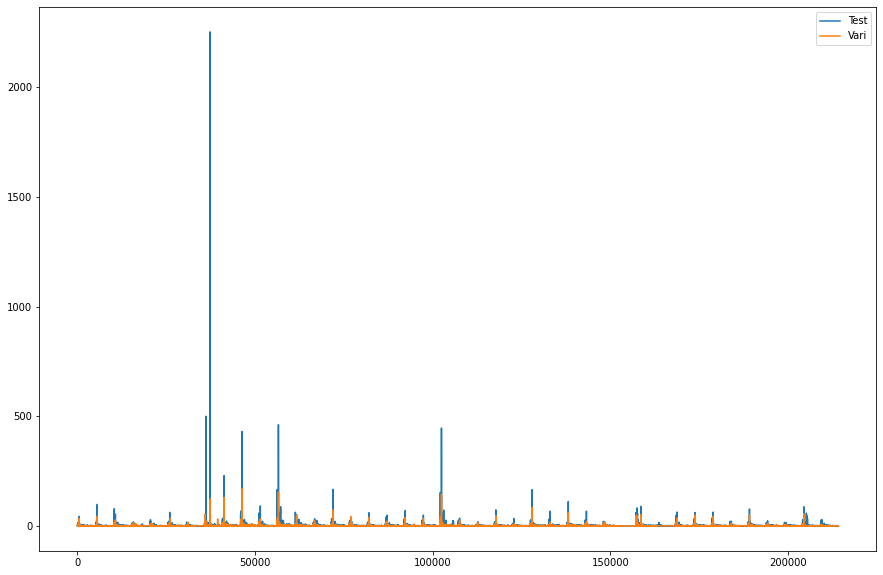

In [16]:
plt.figure(figsize=(15,10), facecolor='white')
plt.plot(Y_vari, label = 'Test')
plt.plot(Vari, label = 'Vari')
plt.legend(loc='best')
plt.show()

In [17]:
sub = Predict.copy()
sub.columns = ['item_cnt_month']
sub['ID'] = sub.index
sub = sub.loc[:, ['ID', 'item_cnt_month']]

print(sub)

sub.to_csv('submisson.csv', index=False)

            ID  item_cnt_month
0            0        0.572244
1            1       -0.063582
2            2        0.811842
3            3        0.046656
4            4       -0.063582
...        ...             ...
214195  214195        0.097490
214196  214196       -0.063582
214197  214197       -0.063582
214198  214198       -0.063582
214199  214199       -0.063582

[214200 rows x 2 columns]
